# Stock, Asset and other Equity Returns Prediction



### 1. A generic algo trading mechanism to deal with pricing prediction of  almost any equity.

### 2. Using Linear Methods, Neural Networks and Ensembled methods.

### 3. Along with time series models - ARIMA and LSTM

##### - Sidharth Purohit

Using correlated assets and historical data to predict the returns of stock price of Microsoft using various Supervised machine learning models.

### Prerequisites 

Factors that are generally useful for stock price prediction are as follows:
#### Correlated assets
An organization depends on and interacts with many external factors, including its competitors, clients, the global economy, the geopolitical situation, fiscal and monetary policies, access to capital, and so on. Hence, its stock price may be correlated not only with the stock price of other companies but also with other assets such as commodities, FX, broad-based indices, or even fixed income securities.

#### Technical indicators
A lot of investors follow technical indicators. Moving average, exponential moving average, and momentum are the most popular indicators.

#### Fundamental analysis
Two primary data sources to glean features that can be used in fundamental
analysis include:

##### Performance reports
Annual and quarterly reports of companies can be used to extract or determine key metrics, such as ROE (Return on Equity) and P/E (Price-to-Earnings).
##### News
News can indicate upcoming events that can potentially move the stock price
in a certain direction

### 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. The data is extracted from Yahoo and FRED financial online database, yfinance and pandas - data reader has been used for the same.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:

    Stocks: IBM (IBM) and Alphabet (GOOGL)
    Currency: USD/JPY and GBP/USD
    Indices: Standard & Poors 500, Dow Jones and VIX



### 2.  Loading the data and python packages

In [39]:
# Loading libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [40]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2. Loading the Data
Next, we extract the data required for our analysis using pandas datareader.

In [41]:
import yfinance as yf

#stock tickers - Microsoft, IBM and Google
stk_tickers = ['MSFT', 'IBM', 'GOOGL'] 

#currency tickers - Exchange b/w Japan and USA, USA and UK
ccy_tickers = ['DEXJPUS', 'DEXUSUK']   

#Index tickers 
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

start_date = '2016-01-01'
end_date = '2020-12-31'


stk_data = yf.download("MSFT IBM GOOGL", start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


In [42]:
ccy_data = web.DataReader(ccy_tickers, 'fred') 
idx_data = web.DataReader(idx_tickers, 'fred')

In [43]:
#The stock data for Google, IBM and Microsoft are being projected, for 10 years.

stk_data.head

<bound method NDFrame.head of            Adj Close                      Close                     High  \
               GOOGL      IBM     MSFT    GOOGL     IBM    MSFT    GOOGL   
Date                                                                       
2015-12-31    778.01  108.035   50.395   778.01  137.62   55.48   788.33   
2016-01-04    759.44  106.724   49.777   759.44  135.95   54.80   762.20   
2016-01-05    761.53  106.646   50.004   761.53  135.85   55.05   769.20   
2016-01-06    759.33  106.112   49.096   759.33  135.17   54.05   765.73   
2016-01-07    741.00  104.299   47.388   741.00  132.86   52.17   755.31   
2016-01-08    730.91  103.333   47.533   730.91  131.63   52.33   750.12   
2016-01-11    733.07  104.589   47.506   733.07  133.23   52.30   735.08   
2016-01-12    745.34  104.330   47.942   745.34  132.90   52.78   748.34   
2016-01-13    719.57  102.972   46.907   719.57  131.17   51.64   753.00   
2016-01-14    731.39  104.338   48.242   731.39  132.91   

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [44]:
return_period= 5

We now define our Y series and our X series

Y: **MSFT** Future Returns

X: A set of features including

x1. GOOGL 5 Business Day Returns
x2. IBM 5 Business Day Returns    
x3. USD/JPY 5 Business Day Returns    
x4. GBP/USD 5 Business Day Returns    
x5. S&P 500 5 Business Day Returns    
x6. Dow Jones 5 Business Day Returns    
x7. MSFT 5 Business Day Returns    
x8. MSFT 15 Business Day Returns    
x9. MSFT 30 Business Day Returns    
x10. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [45]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### 3. Exploratory Data Analysis

#### 3.1. Descriptive Statistics
Lets have a look at the dataset we have

In [46]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,226.000,226.000,2.260e+02,2.260e+02,2.260e+02,226.000,226.000,226.000,226.000,226.000,226.000,226.000
mean,0.006,0.003,-5.488e-04,-3.078e-04,-9.353e-04,0.002,0.001,0.007,0.006,0.018,0.037,0.075
std,0.033,0.035,3.689e-02,1.171e-02,1.526e-02,0.025,0.027,0.166,0.032,0.047,0.060,0.071
min,-0.153,-0.159,-1.683e-01,-4.165e-02,-1.055e-01,-0.162,-0.190,-0.559,-0.145,-0.165,-0.288,-0.134
25%,-0.008,-0.011,-1.697e-02,-6.501e-03,-8.075e-03,-0.005,-0.007,-0.080,-0.007,-0.003,0.007,0.031
50%,0.007,0.008,3.771e-04,1.791e-04,-1.757e-03,0.004,0.003,-0.002,0.007,0.017,0.041,0.079
75%,0.025,0.022,1.705e-02,5.905e-03,7.721e-03,0.013,0.014,0.079,0.024,0.048,0.073,0.121
max,0.100,0.102,1.304e-01,4.038e-02,5.121e-02,0.098,0.121,0.910,0.100,0.186,0.285,0.283


In [47]:
X.describe()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,226.000,2.260e+02,2.260e+02,2.260e+02,226.000,226.000,226.000,226.000,226.000,226.000,226.000
mean,0.003,-5.488e-04,-3.078e-04,-9.353e-04,0.002,0.001,0.007,0.006,0.018,0.037,0.075
std,0.035,3.689e-02,1.171e-02,1.526e-02,0.025,0.027,0.166,0.032,0.047,0.060,0.071
min,-0.159,-1.683e-01,-4.165e-02,-1.055e-01,-0.162,-0.190,-0.559,-0.145,-0.165,-0.288,-0.134
25%,-0.011,-1.697e-02,-6.501e-03,-8.075e-03,-0.005,-0.007,-0.080,-0.007,-0.003,0.007,0.031
50%,0.008,3.771e-04,1.791e-04,-1.757e-03,0.004,0.003,-0.002,0.007,0.017,0.041,0.079
75%,0.022,1.705e-02,5.905e-03,7.721e-03,0.013,0.014,0.079,0.024,0.048,0.073,0.121
max,0.102,1.304e-01,4.038e-02,5.121e-02,0.098,0.121,0.910,0.100,0.186,0.285,0.283


#### 3.2. Data Visualization
Next, lets look at the distribution of the data over the entire period

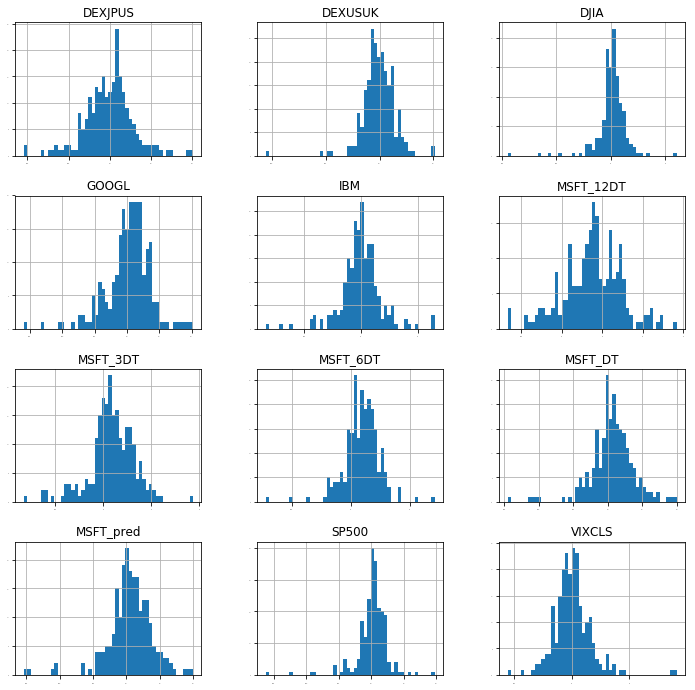

In [48]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

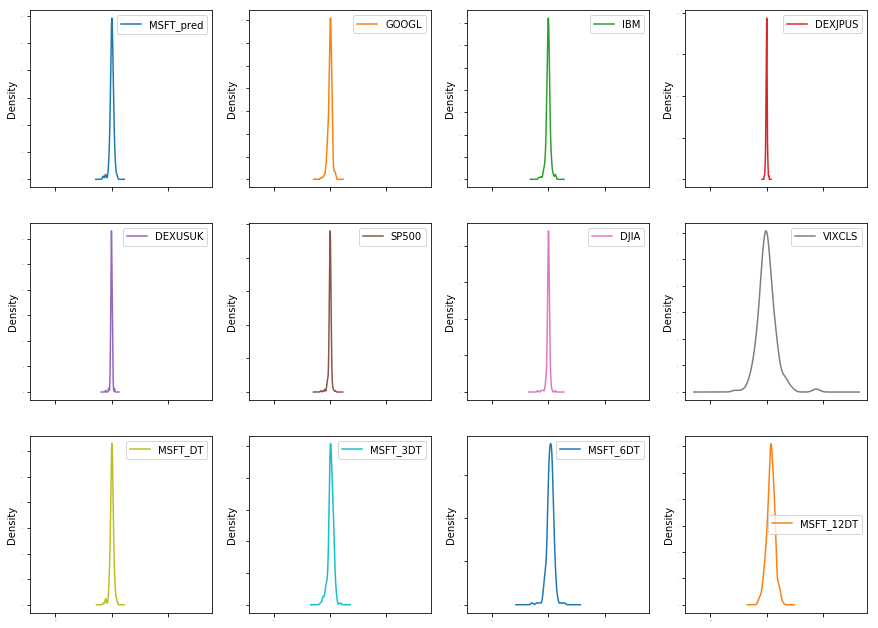

In [49]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.
In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

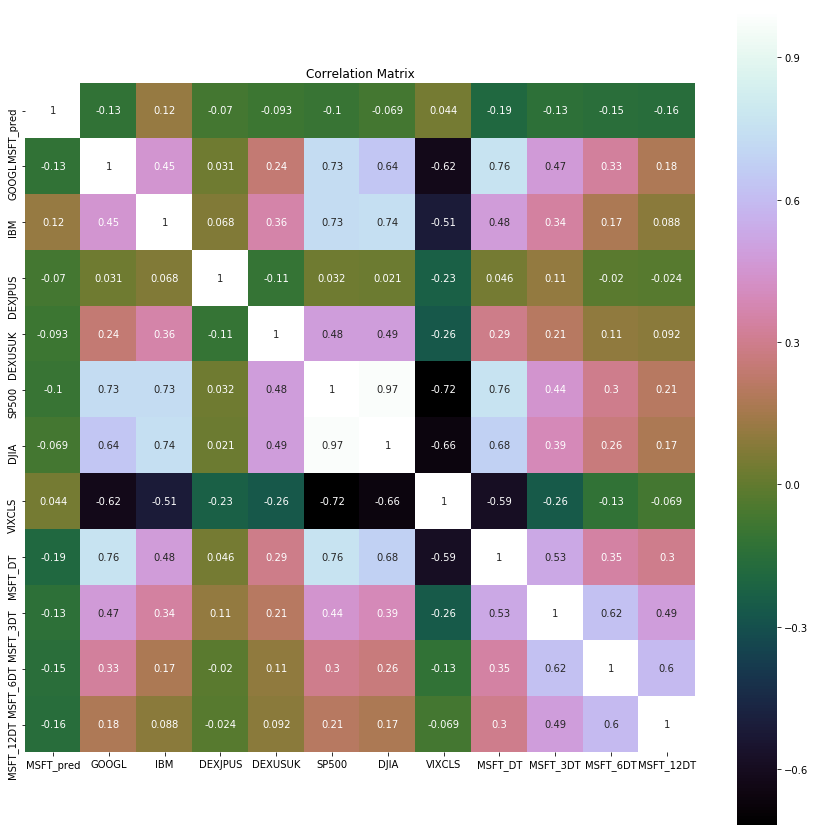

In [50]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

It can be easily observed the inter-dependence between the MSFT shares on its own 5 day, 15 day, 30 day, 60 day lag. Besides, other factors like the indexes too have a greater influence on the MSFT equity.

<Figure size 1080x1080 with 0 Axes>

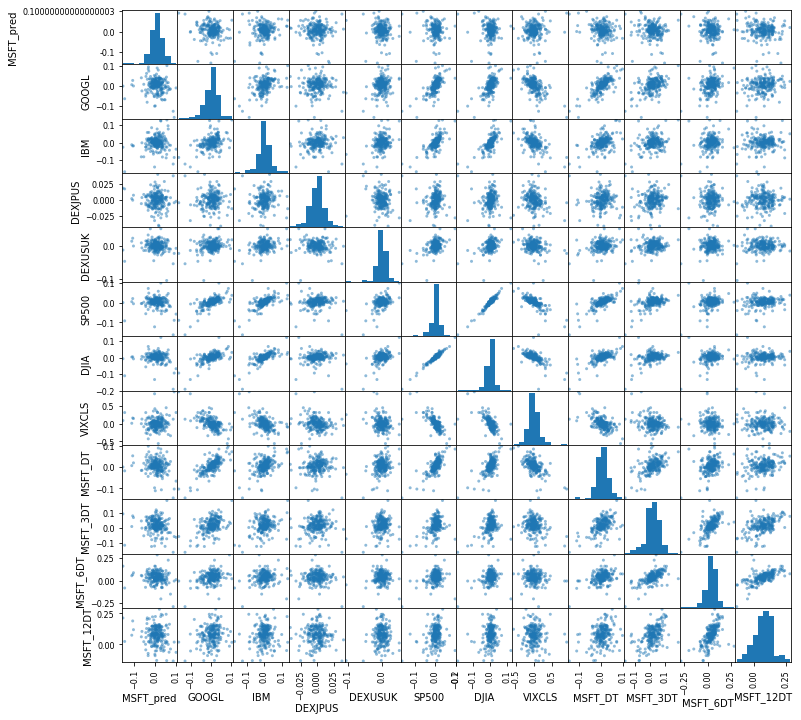

In [51]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship between the predicted variable lagged of 15 days, 30 days and 60 days return of MSFT.

#### 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series. 
First lets define the Time series decompostion :

#### Time Series Breakdown
A time series is a sequence of numbers that are ordered by a time index. 

A time series can be broken down into the following components:
##### Trend Component
A trend is a consistent directional movement in a time series. These trends will
be either deterministic or stochastic. The former allows us to provide an underlying 
rationale for the trend, while the latter is a random feature of a series that we
will be unlikely to explain. Trends often appear in financial series, and many
trading models use sophisticated trend identification algorithms.

#### Seasonal Component
Many time series contain seasonal variation. This is particularly true in series
representing business sales or climate levels. In quantitative finance we often see
seasonal variation, particularly in series related to holiday seasons or annual temperature variation (such as natural gas).
We can write the components of a time series yt as

yt = St + Tt + Rt

where St is the seasonal component, Tt is the trend component, and Rt represents the remainder component of the time series not captured by seasonal or trend component.

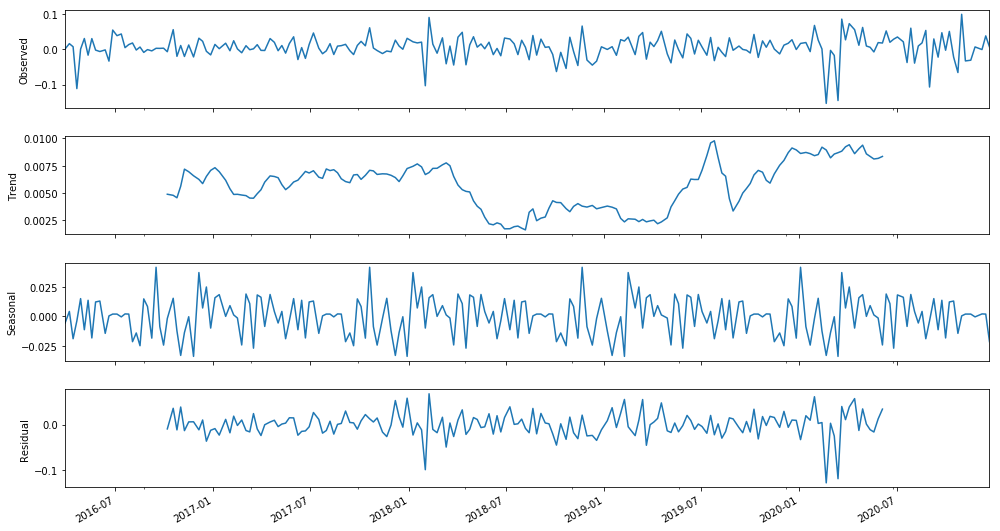

In [52]:
#Here the stats model API has been used to break down the time series data into Trend, 
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards, except for the fiscal period of early 2020, when world was introduced to the global pandemic : COVID-19. This should show up in our the constant/bias terms in our models.

### 4. Data Preparation


#### 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance.

In [53]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,8.498
MSFT_12DT,5.784
MSFT_6DT,5.340
MSFT_3DT,4.133
GOOGL,3.590
IBM,3.085
SP500,2.384
DEXUSUK,1.960
DEXJPUS,1.103


For the considered 10 year duration the MSFT_DT, MSFT_12DT, Google and S&P-500 index are some of the most important features, and the US-UK index and MSFT_3DT are some of the least important features.

### 5. Evaluate Algorithms and Models

#### 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [54]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]



#### 5.2. Test Options and Evaluation Metrics

In [55]:
#10 folds cross validation is being performed. 
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

#### 5.3. Compare Models and Algorithms

##### 5.3.1 Machine Learning models-from scikit-learn
Regression and Tree Regression algorithms


In [56]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [57]:
models.append(('MLP', MLPRegressor()))

#### Ensemble Models

In [58]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [59]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000758 (0.000438) 0.000650 0.002353
LASSO: 0.000715 (0.000403) 0.000713 0.002638
EN: 0.000715 (0.000403) 0.000713 0.002638
KNN: 0.000873 (0.000519) 0.000613 0.002482
CART: 0.001714 (0.000839) 0.000000 0.003959
SVR: 0.001036 (0.000563) 0.000985 0.003012
MLP: 0.001417 (0.000794) 0.001154 0.003570
ABR: 0.000801 (0.000397) 0.000350 0.002701
GBR: 0.000964 (0.000508) 0.000071 0.003505
RFR: 0.000907 (0.000477) 0.000174 0.003082
ETR: 0.000892 (0.000530) 0.000000 0.002745


#### K Fold results
Looking at the K Fold results :


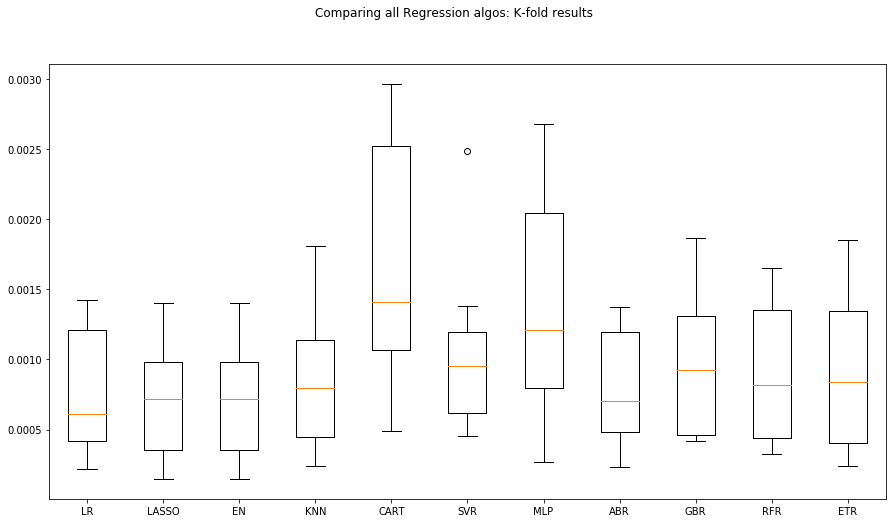

In [60]:
fig = pyplot.figure()
fig.suptitle('Comparing all Regression algos: K-fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

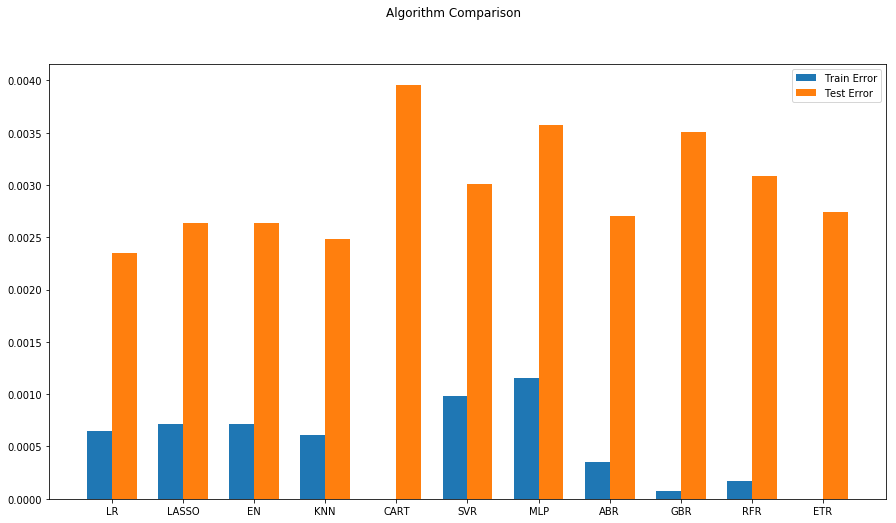

In [61]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the mode

#### 5.3.1 Time Series based models - ARIMA and LSTM

When we are given one or more time series, it is relatively straightforward to decompose the time series into trend, seasonality, and residual components. However, there are other aspects that come into play when dealing with time series data, particularly in finance.

##### Autocorrelation
There are many situations in which consecutive elements of a time series exhibit correlation. That is, the behavior of sequential points in the series affect each other in a dependent manner. Autocorrelation is the similarity between observations as a function of the time lag between them. Such relationships can be modeled using an autoregression model. The term autoregression indicates that it is a regression of the variable against itself.
In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.
Thus, an autoregressive model of order p can be written as

yt = c + ϕ1 yt –1 + ϕ2 yt –2 + ....ϕp yt – p + ϵ
where ϵt is white noise

An autoregressive model is like a multiple regression but with lagged values of yt
as predictors. We refer to this as an AR(p) model, an autoregressive model of order p. Autoregressive models are remarkably flexible at handling a wide range of different time series patterns.

##### Stationarity
A time series is said to be stationary if its statistical properties do not change over time. Thus a time series with trend or with seasonality is not stationary, as the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary, as it does not matter when you observe it; it
should look similar at any point in time.



Let us first prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.
Time Series Model - ARIMA Model

There are many ways to model a time series in order to make predictions. Most of the time series models aim at incorporating the trend, seasonality, and remainder components while addressing the autocorrelation and stationarity embedded in the time series. For example, the autoregressive (AR) model addresses the autocorrelation in the time series.
One of the most widely used models in time series forecasting is the ARIMA model.

#### ARIMA Models :
If we combine stationarity with autoregression and a moving average model, we obtain an ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average, and it has the following
components:

AR(p)
It represents autoregression, i.e., regression of the time series onto itself, with an assumption that current series values depend on its previous values with some lag (or several lags). The maximum lag
in the model is referred to as p.

I(d)
It represents order of integration. It is simply the number of differences needed
to make the series stationary.

MA(q)
It represents moving average. Without going into detail, it models the error of
the time series; again, the assumption is that current error depends on the previous with some lag, which is referred to as q.

The moving average equation is written as:
yt = c + ϵt + θ1ϵt –1 + θ2ϵt –2
where, ϵt is white noise. We refer to this as an MA(q) model of order q.
Combining all the components, the full ARIMA model can be written as:

yt′ = c + ϕ1 yt′–1 + اٴ + ϕp yt′– p + θ1εt –1 + اٴ + θqεt –q + εt

where yt' is the differenced series (it may have been differenced more than once). The
predictors on the right-hand side include both lagged values of yt'
and lagged errors.

We call this an ARIMA(p,d,q) model, where p is the order of the autoregressive part,

d is the degree of first differencing involved, and q is the order of the moving average
part. The same stationarity and invertibility conditions that are used for autoregres‐
sive and moving average models also apply to an ARIMA model.


#### Time Series Model - ARIMA Model

In [62]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [63]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [64]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.002408458002832217

#### LSTM Models
Long short-term memory (LSTM) is a special kind of RNN explicitly designed to
avoid the long-term dependency problem. Remembering information for long periods 
of time is practically default behavior for an LSTM model.

These models are composed of a set of cells with features to memorize the sequence of data. These cells
capture and store the data streams. Further, the cells interconnect one module of the
past to another module of the present to convey information from several past time
instants to the present one. Due to the use of gates in each cell, data in each cell can
be disposed, filtered, or added for the next cells.
The gates, based on artificial neural network layers, enable the cells to optionally let
data pass through or be disposed. Each layer yields numbers in the range of zero to
one, depicting the amount of every segment of data that ought to be let through in
each cell. More precisely, an estimation of zero value implies “let nothing pass
through.” An estimation of one indicates “let everything pass through.” Three types
of gates are involved in each LSTM, with the goal of controlling the state of each cell:

Forget Gate :
Outputs a number between zero and one, where one shows “completely keep
this” and zero implies “completely ignore this.” This gate conditionally decides
whether the past should be forgotten or preserved.


Input Gate :
Chooses which new data needs to be stored in the cell.

Output Gate :
Decides what will yield out of each cell. The yielded value will be based on the
cell state along with the filtered and newly added data.

In [65]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [66]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

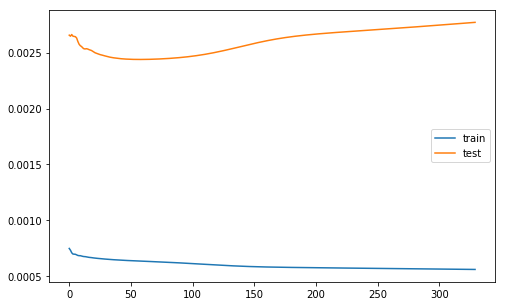

In [67]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [68]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [69]:
#Append to previous results

test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")



### Overall Comparison of all the algorithms ( including Time Series Algorithms)

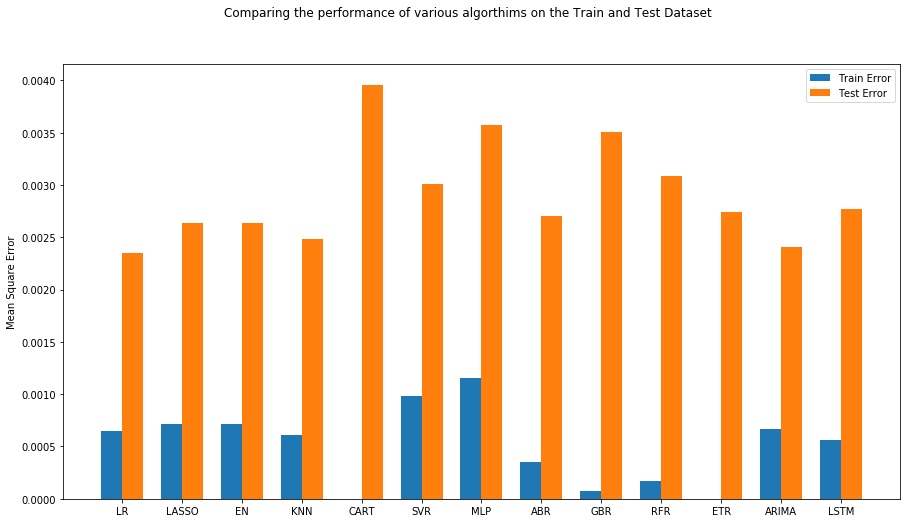

In [70]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐ sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear relationship as discussed before. The LSTM model performs decently, however, ARIMA model outperforms the LSTM model in the test set. Hence, we select the ARIMA model for the model tuning.


### 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.


In [71]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0006891
ARIMA(0, 0, 1) MSE=0.0006648
ARIMA(1, 0, 0) MSE=0.0006689
ARIMA(1, 0, 1) MSE=0.0006648
ARIMA(2, 0, 0) MSE=0.0006632
ARIMA(2, 0, 1) MSE=0.0006491
Best ARIMA(2, 0, 1) MSE=0.0006491


### 7. Finalise the Model

#### 7.1. Results on the Test Dataset


In [72]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [73]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.002408458002832217


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and it can be used for the modeling purpose.

#### 7.2. Save Model for Later Use


In [74]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model_dossier-1.sav'
dump(model_fit_tuned, open(filename, 'wb'))

#Use the following code to produce the comparison of actual vs. predicted
# predicted_tuned.index = Y_test.index
# pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
# pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
# pyplot.rcParams["figure.figsize"] = (8,5)
# pyplot.show()



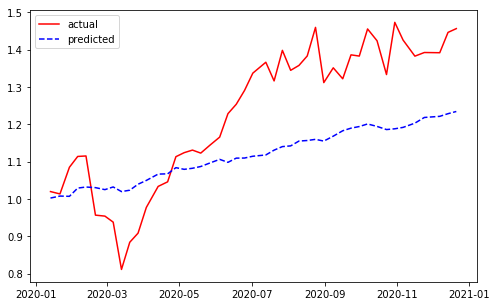

In [75]:
# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

We clearly see the trend has been captured perfectly by the model. The predicted series is less volatile compared 
to the actual time series, and it aligns with the actual data for the first few months of the test set. 
A point to note is that the purpose of the model is to compute the next day’s return given the data
observed up to the present day, and not to predict the stock price several days in the
future given the current data. Hence, a deviation from the actual data is expected as
we move away from the beginning of the test set. The model seems to perform well
for the first few months, with deviation from the actual data increasing six to seven
months after the beginning of the test set


### Summary

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promising modelling approaches for asset price prediction problem. These models can enable financial practitioners to model time dependencies with a very flexible approach. The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction problem in finance. We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.

## Created by - Sidharth Purohit